In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 99SgnZ2U 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 543678.62
  Predicted background counts     : 533641.14
  Predicted excess counts         : 10037.49

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2297944.15

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal m

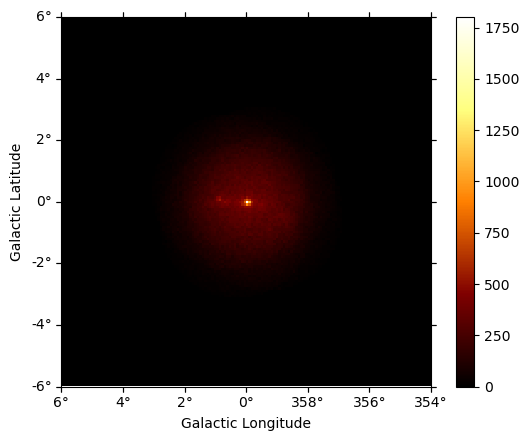

In [3]:
source = 'Galactic Centre'
path = 'C:/Users/yt02izug/Downloads'

dataset_standard = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
#dataset_standard = dataset_standard.downsample(4)
#models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/data/1_model_standard_best_fit_mask.yml")

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
#Values from dataset_standard best fit (without nuisance)
#diff.parameters['tilt'].value = 0.07545879357806834
#diff.parameters['tilt'].error = 0.02658390520205726
#diff.parameters['norm'].value = 2.8506776847212123
#diff.parameters['norm'].error = 0.08440779649209731
diff.parameters['tilt'].frozen = False
models.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models


dataset_standard.models[0].parameters['lon_0'].min = dataset_standard.models[0].parameters['lon_0'].value - 1
dataset_standard.models[0].parameters['lon_0'].max = dataset_standard.models[0].parameters['lon_0'].value + 1
dataset_standard.models[0].parameters['lat_0'].min = dataset_standard.models[0].parameters['lat_0'].value - 1
dataset_standard.models[0].parameters['lat_0'].max = dataset_standard.models[0].parameters['lat_0'].value + 1
dataset_standard.models[1].parameters['lon_0'].min = dataset_standard.models[1].parameters['lon_0'].value - 1
dataset_standard.models[1].parameters['lon_0'].max = dataset_standard.models[1].parameters['lon_0'].value + 1
dataset_standard.models[1].parameters['lat_0'].min = dataset_standard.models[1].parameters['lat_0'].value - 1
dataset_standard.models[1].parameters['lat_0'].max = dataset_standard.models[1].parameters['lat_0'].value + 1
#dataset_standard.models[0].parameters['lon_0'].frozen = True
#dataset_standard.models[0].parameters['lat_0'].frozen = True
#dataset_standard.models[1].parameters['lon_0'].frozen = True
#dataset_standard.models[1].parameters['lat_0'].frozen = True

#create asimov dataset
dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(dataset_standard.models.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models


#create standard dataset with nuisance
dataset_standard_N = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
models_N = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/data/1_model_standard_nuisance_fit_mask.yml")

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
#diff.parameters['tilt'].value = 0.07545879357806834
#diff.parameters['tilt'].error = 0.02658390520205726
#diff.parameters['norm'].value = 2.8506776847212123
#diff.parameters['norm'].error = 0.08440779649209731
diff.parameters['tilt'].frozen = False
models_N.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard_N.name)
bkg_model.parameters['tilt'].frozen  = False
models_N.append(bkg_model)
#irf model
IRFmodel = IRFModel(dataset_name = dataset_standard_N.name)
IRFmodel.parameters['bias'].frozen  = True
IRFmodel.parameters['resolution'].frozen  = True
IRFmodel.parameters['tilt_nuisance'].frozen  = False
models_N.append(IRFmodel)
dataset_standard_N.models = models_N
#dataset_standard_N.models.parameters['norm_nuisance'].value  = 0.0
#dataset_standard_N.models.parameters['tilt_nuisance'].value  = 0.0
#dataset_standard_N.exposure = dataset_standard_N.npred_exposure()
zero = 1e-24
shift = 0.1
tilt = 0.015
## additional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift**2, 1/tilt**2, 1/zero**2, 1/zero**2])
dataset_standard_N.penalising_invcovmatrix = penalising_invcovmatrix

dataset_standard_N.models[0].parameters['lon_0'].frozen = True
dataset_standard_N.models[0].parameters['lat_0'].frozen = True
dataset_standard_N.models[1].parameters['lon_0'].frozen = True
dataset_standard_N.models[1].parameters['lat_0'].frozen = True


#Input Model for Comparison
dataset_input = dataset_standard.copy()
models_input = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
models_input.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_input.name)
bkg_model.parameters['tilt'].frozen  = False
models_input.append(bkg_model)
dataset_input.models = models

#set mask to exclude J1745
j1745_coord = SkyCoord(358.6435538, -0.5617789, unit='deg',frame='galactic')
skyregion_1745 = RectangleSkyRegion(center=j1745_coord, width=1*u.deg,height=1*u.deg)#, angle = 108*u.deg)
geom = dataset_standard.counts.geom
mask_space = ~geom.region_mask([skyregion_1745])
dataset_standard.mask_fit = mask_space
dataset_asimov.mask_fit = mask_space

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [4]:
savefig = True
picformat = 'svg'

shift = 0.10 #0.085
tilt = 0.015

In [5]:
sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                        rnd = False)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N()

zero = 1e-24
## additional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift**2, 1/tilt**2, 1/zero**2, 1/zero**2])
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_standard_N.penalising_invcovmatrix = penalisng_inv_cov_matrix

#fit_cor = Fit(store_trace=False)
#minuit_opts = {"tol": 0.001, "strategy": 2}
#fit_cor.backend = "minuit"
#fit_cor.optimize_opts = minuit_opts
#result_cor = fit_cor.run([dataset_asimov])

#fit_cor_N = Fit(store_trace=False)
#minuit_opts = {"tol": 0.001, "strategy": 2}
#fit_cor_N.backend = "minuit"
#fit_cor_N.optimize_opts = minuit_opts
#result_cor_N = fit_cor_N.run([dataset_asimov_N])

fit_st = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_st.backend = "minuit"
fit_st.optimize_opts = minuit_opts
result_st = fit_st.run([dataset_standard])

fit_st_N = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_st_N.backend = "minuit"
fit_st_N.optimize_opts = minuit_opts
result_st_N = fit_st_N.run([dataset_standard_N])

In [6]:
dataset_asimov_N.models[-1].parameters['norm_nuisance'].frozen = True
dataset_asimov_N.models[-1].parameters['tilt_nuisance'].frozen = True
dataset_standard_N.models[-1].parameters['norm_nuisance'].frozen = True
dataset_standard_N.models[-1].parameters['tilt_nuisance'].frozen = True

In [7]:
mask = dataset_standard.mask.data[:,60,60]
ebins = dataset_standard.counts.geom.axes[0].center[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV

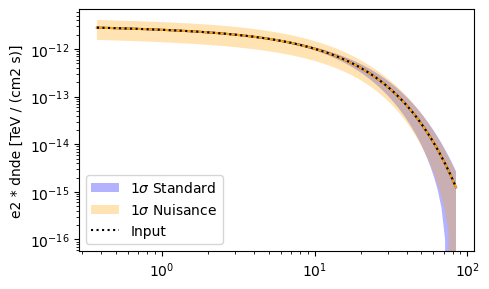

In [8]:
true_energy = dataset_standard.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, axs = plt.subplots(1,1, figsize = (5,3)) 
    
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "blue", alpha = 0.9)    

dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "blue", alpha = 0.3)

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "orange")    

dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "orange", alpha = 0.3)   

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )

axs.set_xlabel('')
axs.legend()
plt.tight_layout()

## Compute Asimov Fluxpoints with Standard Dataset


In [9]:
%%time
compute_fluxpoints = 1
if compute_fluxpoints:
    energy_edges = dataset_standard.geoms['geom'].axes[0].edges
    esti  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = False)
    fluxpoints_standard = esti.run([dataset_standard])
    fluxpoints_standard.write("data/6_fluxpoints_standard.fits", overwrite = True)
else:
    fluxpoints_standard = FluxPoints.read("data/6_fluxpoints_standard.fits")
    

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0.062272810501454466
norm 1.000001106087241 0.054743112990453806
norm 1.0 0.05321778112316086
norm 1.0000006981453793 0.053691901096142615
norm 1.000001081896784 0.0569219653872898
norm 1.0000012129510838 0.060818059848470864
norm 1.0000010894859095 0.06770377662042128
norm 1.0000013671355 0.07669056762220476
norm 1.000001418418363 0.08898520633844938
norm 1.0000007511127922 0.10692180375895696
norm 1.0 0.13250382562093882
norm 1.0 0.16404323628484463
norm 1.0 0.21283779637821845
norm 1.0 0.29059357841917366
norm 1.0 0.4176620667875876
norm 1.0000000686456052 0.666674853054619
norm 1.0 1.1952427975690514
norm 1.0 2.5484745231148294
norm 1.0 7.316246262447686
norm 1.0 33.56589114263073
CPU times: total: 33.3 s
Wall time: 33.6 s


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


In [10]:
%%time
if compute_fluxpoints:

    esti_N  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = True)
    ## modify the covariance matrix, because only one nuisance parameter here
    #penalising_covmatrix = [[1/sigma_a**2]]
    #penalising_invcovmatrix =  penalising_covmatrix
    #dataset_standard_N.penalising_invcovmatrix = penalising_invcovmatrix
    with dataset_standard_N.models.restore_status():
        dataset_standard_N.models.parameters.freeze_all()
        dataset_standard_N.models.parameters['norm_nuisance'].frozen = False
        dataset_standard_N.models.parameters['tilt_nuisance'].frozen = False
        fluxpoints_standard_N = esti_N.run([dataset_standard_N])

    fluxpoints_standard_N.write("data/6_fluxpoints_standard_N.fits", overwrite = True)
else:
    fluxpoints_standard_N = FluxPoints.read("data/6_fluxpoints_standard_N.fits",)

norm 1.0 0
norm_nuisance 6.692237946081012e-06 0.44807765921679343
tilt_nuisance -7.017479103687929e-06 0.014461495073124124
bias 0.0 0.0
resolution 0.0 0.0
freeze for error
freeze for error
freeze for error
freeze for error
norm 1.0 0
norm_nuisance 6.692237946081012e-06 0.44807765921679343
tilt_nuisance -7.017479103687929e-06 0.014461495073124124
bias 0.0 0.0
resolution 0.0 0.0
freeze for error
freeze for error
freeze for error
freeze for error
norm 1.0 0
norm_nuisance 6.692237946081012e-06 0.44807765921679343
tilt_nuisance -7.017479103687929e-06 0.014461495073124124
bias 0.0 0.0
resolution 0.0 0.0
freeze for error
freeze for error
freeze for error
freeze for error
norm 1.0 0
norm_nuisance 6.692237946081012e-06 0.44807765921679343
tilt_nuisance -7.017479103687929e-06 0.014461495073124124
bias 0.0 0.0
resolution 0.0 0.0
freeze for error
freeze for error
freeze for error
freeze for error
norm 1.0000889154952641 0.1110057125321363
norm_nuisance 6.6922378320289695e-06 0.08165045228291598


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


In [11]:
def plot_shifted (ff, shift):
    return ff.energy_ref* shift, ff.e2dnde.data[:,0,0],  ff.e2dnde_err.data[:,0,0], 

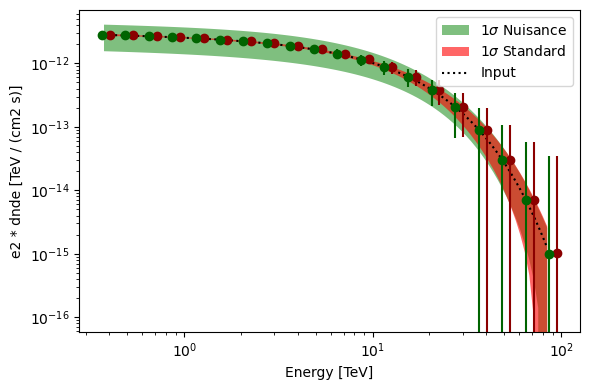

In [12]:
fig, axs = plt.subplots(1,1, figsize = (6,4))
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.6)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )




e_, f_, ferr_ = plot_shifted(fluxpoints_standard, 1.1)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='o')  

e_, f_, ferr_ = plot_shifted(fluxpoints_standard_N, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='o')  


axs.legend()
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/6_fluxpoints_standard."+ picformat)
